In [2]:
import datetime
import os
import time
from sklearn.preprocessing import MinMaxScaler


import pandas as pd
from openpyxl import load_workbook

import Optim
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from datetime import datetime
import math

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, MultipleLocator

from hurst import compute_Hc

from layer import DenseGraphConv


np.seterr(divide='ignore',invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [1]:
import os

# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print(f"현재 작업 디렉토리: {current_directory}")

# 변경하고자 하는 디렉토리 경로
new_directory = 'C:/Users/sangheon/Desktop/Hurst_TE_RealizedVol'

# 작업 디렉토리 변경
os.chdir(new_directory)

# 변경된 작업 디렉토리 확인
new_current_directory = os.getcwd()
print(f"변경된 작업 디렉토리: {new_current_directory}")


현재 작업 디렉토리: C:\Program Files\JetBrains\PyCharm 2024.1.4\jbr\bin
변경된 작업 디렉토리: C:\Users\sangheon\Desktop\Hurst_TE_RealizedVol


In [3]:
# 각 값이 어떤 bin에 속하는지 인덱싱
def value_to_bin(value_list, m, M, increments):
    result = []
    for v in value_list:
        m_increments = m;
        bin_increments = 0
        while (m_increments < v):
            m_increments = m_increments + increments
            bin_increments = bin_increments + 1
        result.append(bin_increments)
    return result

# calculate omega
def error_cov_matrix(sigma, tau, P):
    matrix = np.diag(np.diag(P.dot(tau * sigma).dot(P.T)))
    return matrix


inc = 0.01
n_random = 25


def TE_caculate(X, increments=inc):
    
    # 최대값, 최소값, bin size
    M = np.max(X)
    M_ceil = np.ceil(M / increments) * increments  # 반올림
    m = np.min(X)
    m_floor = np.floor(m / increments) * increments  # 반내림

    # calculate TE
    TE_matrix = np.zeros((X.shape[1], X.shape[1]))
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            if i == j:
                continue
            else:
                # print(v, '->', w)
                xn1 = [r[j] for r in X][1:]
                xn = [r[j] for r in X][:-1]
                yn = [r[i] for r in X][:-1]

                # binning
                xn1_bin = value_to_bin(xn1, m_floor, M_ceil, increments)
                xn_bin = value_to_bin(xn, m_floor, M_ceil, increments)
                yn_bin = value_to_bin(yn, m_floor, M_ceil, increments)

                # bin freq
                xn_freq = list(np.unique(np.array(xn_bin), return_counts=True))
                xn_freq.append(xn_freq[1] / sum(xn_freq[1]))
                xn_xn1_freq = list(np.unique(np.array([xn_bin, xn1_bin]).T, return_counts=True, axis=0))
                xn_xn1_freq.append(xn_xn1_freq[1] / sum(xn_xn1_freq[1]))
                xn_yn_freq = list(np.unique(np.array([xn_bin, yn_bin]).T, return_counts=True, axis=0))
                xn_yn_freq.append(xn_yn_freq[1] / sum(xn_yn_freq[1]))
                xn_xn1_yn_freq = list(np.unique(np.array([xn_bin, xn1_bin, yn_bin]).T, return_counts=True, axis=0))
                xn_xn1_yn_freq.append(xn_xn1_yn_freq[1] / sum(xn_xn1_yn_freq[1]))

                # calculate TE
                TE_xy = 0
                for ii, vv in enumerate(xn_xn1_yn_freq[0]):
                    p_in_in1_jn = xn_xn1_yn_freq[2][ii]
                    index_in_in1 = xn_xn1_freq[0].tolist().index(vv[:2].tolist())
                    p_in_in1 = xn_xn1_freq[2][index_in_in1]
                    index_in_jn = xn_yn_freq[0].tolist().index(vv[[0, 2]].tolist())
                    p_in_jn = xn_yn_freq[2][index_in_jn]
                    index_in = xn_freq[0].tolist().index(vv[0])
                    p_in = xn_freq[2][index_in]
                    TE_xy = TE_xy + p_in_in1_jn * np.log2(p_in_in1_jn * p_in / p_in_in1 / p_in_jn)
                TE_matrix[i, j] = TE_xy

    return TE_matrix


def ETE_caculate(X, TE_matrix, increments=inc):
    
    # 최대값, 최소값, bin size
    M = np.max(X);
    M_ceil = np.ceil(M / increments) * increments  # 반올림
    m = np.min(X);
    m_floor = np.floor(m / increments) * increments  # 반내림
    
    # calculate RTE
    RTE_matrix_all = np.zeros([X.shape[1], X.shape[1], n_random])
    for nn in range(n_random):
        # returns_shuffle = np.array(X).T.tolist()
        # random.shuffle(returns_shuffle)
        # returns_shuffle = np.array(returns_shuffle).T.tolist()
        RTE_matrix = np.zeros((X.shape[1], X.shape[1]))
        for i in range(X.shape[1]):
            for j in range(X.shape[1]):
                if i==j:
                    continue
                else:
                    xn1 = [r[j] for r in X][1:]
                    xn = [r[j] for r in X][:-1]
                    yn = [r[i] for r in X][:-1]
                    # binning
                    xn1_bin = value_to_bin(xn1, m_floor, M_ceil, increments)
                    xn_bin = value_to_bin(xn, m_floor, M_ceil, increments)
                    yn_bin = value_to_bin(yn, m_floor, M_ceil, increments)
                    np.random.shuffle(yn_bin)
    
                    # bin freq
                    xn_freq = list(np.unique(np.array(xn_bin), return_counts=True))
                    xn_freq.append(xn_freq[1]/sum(xn_freq[1]))
                    xn_xn1_freq = list(np.unique(np.array([xn_bin, xn1_bin]).T, return_counts=True, axis=0))
                    xn_xn1_freq.append(xn_xn1_freq[1]/sum(xn_xn1_freq[1]))
                    xn_yn_freq = list(np.unique(np.array([xn_bin, yn_bin]).T, return_counts=True, axis=0))
                    xn_yn_freq.append(xn_yn_freq[1]/sum(xn_yn_freq[1]))
                    xn_xn1_yn_freq = list(np.unique(np.array([xn_bin, xn1_bin, yn_bin]).T, return_counts=True, axis=0))
                    xn_xn1_yn_freq.append(xn_xn1_yn_freq[1]/sum(xn_xn1_yn_freq[1]))
                    # calculate RTE
                    RTE_xy = 0
                    for ii, vv in enumerate(xn_xn1_yn_freq[0]):
                        p_in_in1_jn = xn_xn1_yn_freq[2][ii]
                        index_in_in1 = xn_xn1_freq[0].tolist().index(vv[:2].tolist())
                        p_in_in1 = xn_xn1_freq[2][index_in_in1]
                        index_in_jn = xn_yn_freq[0].tolist().index(vv[[0, 2]].tolist())
                        p_in_jn = xn_yn_freq[2][index_in_jn]
                        index_in = xn_freq[0].tolist().index(vv[0])
                        p_in = xn_freq[2][index_in]
                        RTE_xy = RTE_xy + p_in_in1_jn * np.log2(p_in_in1_jn * p_in / p_in_in1 / p_in_jn)
                    RTE_matrix[i, j] = RTE_xy
        RTE_matrix_all[:,:,nn] = RTE_matrix
        # calculate ETE
    
    ETE_matrix = np.zeros((X.shape[1], X.shape[1]))
    for i in range(X.shape[1]) :
        for j in range(X.shape[1]):
            if i == j:
                continue
            TE = TE_matrix[i, j]
            rte_array = RTE_matrix_all[i, j, :]
            if TE - np.mean(rte_array) - np.std(rte_array) / n_random ** 0.5 > 0:
                ETE_matrix[i, j] = TE - np.mean(rte_array)
                
    if np.all(ETE_matrix == 0) :
        matrix = np.full((10, 10), 0.001)
        np.fill_diagonal(matrix, 0)
        return matrix
        
    return ETE_matrix

In [4]:
class TENet(nn.Module):
    def __init__(self, args, A, B, window_size):
        super(TENet, self).__init__()
        self.use_cuda = args.CUDA
        self.batch_size = args.BATCH_SIZE
        self.window_size = window_size

        # A와 B 초기화
        A = np.array(A, dtype=np.float32)
        A = A / np.sum(A)
        A_new = np.zeros((args.BATCH_SIZE, args.N_E, args.N_E), dtype=np.float32)
        for i in range(args.BATCH_SIZE):
            A_new[i, :, :] = A

        self.A = torch.from_numpy(A_new).cuda() if self.use_cuda else torch.from_numpy(A_new)
        self.adjs = [self.A]
        self.num_adjs = args.NUM_ADJ
        if self.num_adjs > 1:
            A = np.array(B, dtype=np.float32)
            A = A / np.sum(A, 1)
            A_new = np.zeros((args.BATCH_SIZE, args.N_E, args.N_E), dtype=np.float32)
            for i in range(args.BATCH_SIZE):
                A_new[i, :, :] = A

            self.B = torch.from_numpy(A_new).cuda() if self.use_cuda else torch.from_numpy(A_new)
            self.C = torch.from_numpy(A_new).cuda()
            self.adjs = [self.A,self.B,self.C]

        self.n_e = args.N_E

        # Conv2d 레이어
        self.conv1=nn.Conv2d(1, args.CHANNEL_SIZE, kernel_size = (1,args.K_SIZE[0]),stride=1)
        self.conv2=nn.Conv2d(1, args.CHANNEL_SIZE, kernel_size = (1,args.K_SIZE[1]),stride=1)
        self.conv3=nn.Conv2d(1, args.CHANNEL_SIZE, kernel_size = (1,args.K_SIZE[2]),stride=1)


        # Conv2d의 출력 차원 계산
        d= (len(args.K_SIZE)*(self.window_size) -sum(args.K_SIZE)+ len(args.K_SIZE))*args.CHANNEL_SIZE

        # GNN 레이어
        self.gnn1 = DenseGraphConv(d, args.HID1)
        self.gnn2 = DenseGraphConv(args.HID1, args.HID2)
        self.gnn3 = DenseGraphConv(args.HID2, 1)

        # Highway layer
        self.hw = args.HIGHWAY_WINDOW
        if self.hw > 0:
            self.highway = nn.Linear(self.hw, 1)

    def forward(self,x):
        c=x.permute(0,2,1)
        c=c.unsqueeze(1)
        # if self.decoder != 'GAT':
        a1=self.conv1(c).permute(0,2,1,3).reshape(self.batch_size,self.n_e,-1)
        a2=self.conv2(c).permute(0,2,1,3).reshape(self.batch_size,self.n_e,-1)
        a3=self.conv3(c).permute(0,2,1,3).reshape(self.batch_size,self.n_e,-1)

        x_conv = F.relu(torch.cat([a1, a2, a3], 2))
        # x_conv=F.relu(torch.cat([a1,a2,a3,a4,a5],2))
        x1 = F.relu(self.gnn1(x_conv,self.A))
        x2 = F.relu(self.gnn2(x1,self.A))
        x3 = self.gnn3(x2,self.A)
        x3 = x3.squeeze()
      

        if self.hw>0:
            z = x[:, -self.hw:, :]
            z = z.permute(0, 2, 1)
            z = self.highway(z)
            z = z.squeeze(2)
            x3 = x3 + z
        return x3



100%|██████████| 5103/5103 [00:03<00:00, 1514.98it/s]


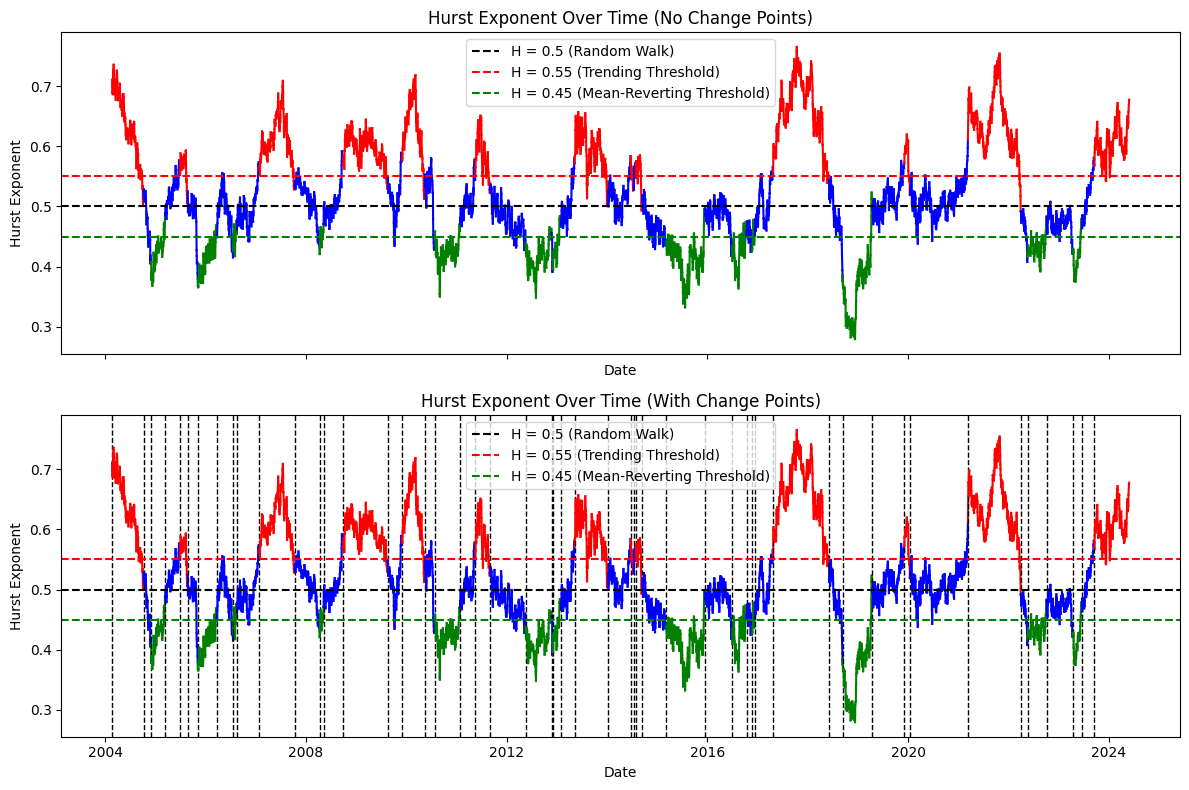

In [5]:
# CSV 파일에서 데이터 읽어오기 (파일명과 경로를 지정하세요)
file_path = 'data/df_world.csv'  # 실제 CSV 파일 경로로 수정하세요.
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# 로그 리턴 계산
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Hurst exponent를 계산할 창(window)의 크기 설정 (252 거래일 = 1년)
window_size = 250

# Hurst exponent를 저장할 리스트
hurst_series = []

# 날짜를 저장할 리스트
dates_series = []

# 슬라이딩 윈도우를 통해 Hurst exponent 계산
for i in range(window_size, len(df)):
    window_data = df['Log_Return'].iloc[i-window_size:i].dropna()
    H, _, _ = compute_Hc(window_data, kind='change', simplified=True)
    hurst_series.append(H)
    dates_series.append(df.index[i])

# 결과를 시계열 데이터로 변환
hurst_df = pd.DataFrame(data={'Hurst': hurst_series}, index=dates_series)

# 서브플롯을 설정
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 색상 변경 시점 추적을 위한 변수
prev_color = 'blue'
color_changes = []
num_prev_colors = 7

# 색상 변경 점선 없는 서브플롯
for i in range(10, len(hurst_df)):
    recent_10_days = hurst_df['Hurst'].iloc[i-10:i]
    
    count_above_55 = (recent_10_days >= 0.55).sum()
    count_between_45_and_55 = ((recent_10_days < 0.55) & (recent_10_days >= 0.45)).sum()
    count_below_45 = (recent_10_days < 0.45).sum()
    
    if count_above_55 >= num_prev_colors:
        color = 'red'
    elif count_between_45_and_55 >= num_prev_colors:
        color = 'blue'
    elif count_below_45 >= num_prev_colors:
        color = 'green'
    else:
        color = prev_color
    
    axs[0].plot(hurst_df.index[i-1:i+1], hurst_df['Hurst'].iloc[i-1:i+1], color=color)
    
    # 색상 변경 시점 기록
    if color != prev_color:
        color_changes.append(hurst_df.index[i])
        prev_color = color

# 색상 변경 점선 있는 서브플롯
prev_color = 'blue'
for i in tqdm(range(10, len(hurst_df))):
    recent_10_days = hurst_df['Hurst'].iloc[i-10:i]
    
    count_above_55 = (recent_10_days >= 0.55).sum()
    count_between_45_and_55 = ((recent_10_days < 0.55) & (recent_10_days >= 0.45)).sum()
    count_below_45 = (recent_10_days < 0.45).sum()
    
    if count_above_55 >= num_prev_colors:
        color = 'red'
    elif count_between_45_and_55 >= num_prev_colors:
        color = 'blue'
    elif count_below_45 >= num_prev_colors:
        color = 'green'
    else:
        color = prev_color
    
    axs[1].plot(hurst_df.index[i-1:i+1], hurst_df['Hurst'].iloc[i-1:i+1], color=color)
    
    # 색상 변경 시점에 점선 추가
    if color != prev_color:
        axs[1].axvline(hurst_df.index[i], color='black', linestyle='--', linewidth=1)
        prev_color = color

# 기준선 추가
for ax in axs:
    ax.axhline(0.5, color='black', linestyle='--', label='H = 0.5 (Random Walk)')
    ax.axhline(0.55, color='red', linestyle='--', label='H = 0.55 (Trending Threshold)')
    ax.axhline(0.45, color='green', linestyle='--', label='H = 0.45 (Mean-Reverting Threshold)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Hurst Exponent')
    ax.legend()

# 서브플롯 제목
axs[0].set_title('Hurst Exponent Over Time (No Change Points)')
axs[1].set_title('Hurst Exponent Over Time (With Change Points)')

# 그래프 설정
plt.tight_layout()
plt.show()

In [6]:
# 날짜만 추출하여 문자열 리스트로 변환
color_changes = [ts.date().strftime('%Y-%m-%d') for ts in color_changes]


In [ ]:
class WindowedDataset(Dataset):
    def __init__(self, data, data_y, window_size, horizon, scaler_x, scaler_y):
        self.data = data
        self.data_y = data_y
        self.window_size = window_size
        self.horizon = horizon
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y
    
    def __len__(self):
        return len(self.data) - self.window_size - self.horizon + 1
    
    def __getitem__(self, idx):
        # 데이터 슬라이스 추출
        window_data = self.data[idx:idx + self.window_size]
        label = self.data_y[idx]

        # 스케일링 (사전에 학습된 스케일러 사용)
        window_scaled = self.scaler_x.transform(window_data)
        
        # 1차원 배열을 2차원 배열로 변환
        label_scaled = self.scaler_y.transform(np.array([label]))
        
        return torch.tensor(window_scaled, dtype=torch.float32), torch.tensor(label_scaled.flatten(), dtype=torch.float32)

In [10]:
class ModelManager:
    def __init__(self, config, data, window_size, threshold, Effective, training_period):
        self.config = config
        self.window_size = window_size
        self.raw_data = data
        self.data_np = np.array(data.iloc[:, 1:])
        self.data_y = self.calculate_realized_volatility(self.data_np, self.window_size)  # 실현 변동성 계산
        self.training_period = training_period
        self.threshold = threshold
        self.Effective = Effective
        self.device = torch.device(config.DEVICE)
        self.model = None
        self.criterion = nn.MSELoss().to(self.device)
        self.optimizer = None
        self.A = None
        self.B = None
        self.results = []
        self.scaler_x = MinMaxScaler(feature_range=(0, 1))
        self.scaler_y = MinMaxScaler(feature_range=(0, 1))

        self.save_dir = None

        self.test_total_loss_list = []
        self.test_each_loss_list = []  # test_each_loss_list 초기화
        self.predictions = []  # 예측 값을 저장할 리스트
        self.actuals = []  # 실제 값을 저장할 리스트

        
    def calculate_realized_volatility(self, data, window):
        realized_vols = []
        for i in range(20, len(data)):
            window_data = data[i-20:i]  # 30일치 데이터 슬라이스
            window_data = 100 * window_data
            squared_returns = np.square(window_data)  # 제곱
            realized_vol = np.sqrt(np.mean(squared_returns, axis=0))  # 평균 계산 후 제곱근
            realized_vols.append(realized_vol)
        result = realized_vols[window-20:]
        return np.array(result)

    def load_model(self, A, B, window_size):
        torch.cuda.empty_cache()
        return TENet(CONFIG, A, B, window_size).to(self.device)  # GNN 모델 생성

    def calculate_TE(self, data, Effective):
        if Effective:
            TE_matrix = TE_caculate(data)
            ETE_matrix = ETE_caculate(data, TE_matrix)
            return ETE_matrix
        else:
            TE_matrix = TE_caculate(data)
            return TE_matrix

    def update_A_B(self, matrix):
        self.A = matrix
        self.B = matrix

    def calculate_hurst(self, data):
        hurst_value = compute_Hc(data)[0]
        return hurst_value

    
    def train_and_evaluate(self):
        initial_data_x = self.data_np[:self.training_period]
        initial_data_y = self.data_y[:self.training_period-self.window_size]
        
        print("initial_data_x and y", initial_data_x.shape, initial_data_y.shape)
        te_matrix = self.calculate_TE(initial_data_x, self.Effective)
        self.model = self.load_model(te_matrix, te_matrix, self.window_size)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.LR)
        
        self.train_model(initial_data_x, initial_data_y)
        
        
        num_change = 0
        
        for day in tqdm(range(self.training_period, len(self.data_np) - self.window_size)):
            start_idx = max(0, day - self.training_period)
            
            
            # 국면 전환 시점 확인
            current_date = self.raw_data['Date'].iloc[day]

            if current_date in color_changes:  # 국면 전환 시점에서 모델 재학습
                TV_data_x = self.data_np[start_idx:day]
                TV_data_y = self.data_y[start_idx:day-self.window_size]
                # 새로운 국면에서 TE 재계산 및 GNN 재학습
                te_matrix = self.calculate_TE(TV_data_x, self.Effective)
                self.model = self.load_model(te_matrix, te_matrix, self.window_size)
                self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.LR)
                
                self.train_model(TV_data_x, TV_data_y)
                print("Retrain shape : ", TV_data_x.shape, TV_data_y.shape)
                print(f"Change on day {current_date}.")
                num_change += 1

            
            # 매일 실현 변동성 예측 및 손실 계산
            test_x = self.data_np[day:day + self.window_size]
            test_y = self.data_y[day].reshape(1, -1)  # test_y는 2차원으로 reshape
            
            # 스케일링
            scaled_test_x = self.scaler_x.transform(test_x)
            scaled_test_y = self.scaler_y.transform(test_y)
            
            # 배치 크기만큼 복사하여 데이터 확장
            batch_size = self.config.BATCH_SIZE  # 사용할 배치 크기
            scaled_test_x = np.tile(scaled_test_x, (batch_size, 1, 1))  # (batch_size, window_size, features)
            scaled_test_y = np.tile(scaled_test_y, (batch_size, 1))     # (batch_size, features)
  
            # 예측 및 평가
            self.model.eval()
            with torch.no_grad():
                # 입력 데이터를 텐서로 변환
                test_x_tensor = torch.tensor(scaled_test_x, dtype=torch.float32).to(self.device)
                test_y_tensor = torch.tensor(scaled_test_y, dtype=torch.float32).to(self.device)
            
                # 모델 예측
                predictions = self.model(test_x_tensor)
                # 손실 계산 (배치 내 손실의 평균)
                loss = self.criterion(predictions, test_y_tensor)
            
                # 결과 저장
                self.test_total_loss_list.append(loss.item())
            
            pred = self.scaler_y.inverse_transform(predictions.cpu().detach().numpy())
            self.predictions.append(pred[0])
            self.actuals.append(test_y)
            
        print("Number of chage : ", num_change)

    def train_model(self, x, y):
        self.model.train()  # Set the model to training mode
        
        train_split = int(self.training_period * 0.7)
        train_x = x[:train_split]
        val_x = x[train_split:]
        train_y = y[:train_split]
        val_y = y[train_split:]
        
        self.scaler_x.fit(train_x)
        self.scaler_y.fit(train_y)
        
        # 학습 데이터, 검증 데이터 준비
        train_loader = DataLoader(WindowedDataset(train_x, train_y, self.window_size, self.config.HORIZON, self.scaler_x, self.scaler_y), batch_size=self.config.BATCH_SIZE, shuffle=True, drop_last=True)
        val_loader = DataLoader(WindowedDataset(val_x, val_y, self.window_size, self.config.HORIZON, self.scaler_x, self.scaler_y), batch_size=self.config.BATCH_SIZE, shuffle=False, drop_last=True)
        
        best_val_loss = float('inf')
        best_model_state = None
    
        for epoch in range(self.config.EPOCHS):
            train_total_loss, _ = self.train_epoch(train_loader)
            val_total_loss, _ = self.evaluate_epoch(val_loader)            

            # validation loss가 최저일 때 모델을 저장
            if val_total_loss < best_val_loss:
                best_val_loss = val_total_loss
                best_model_state = self.model.state_dict()  # 모델의 가중치 저장
        
        self.model.load_state_dict(best_model_state)


    def train_epoch(self, train_loader):
        total_loss = 0
        each_loss = torch.zeros(self.data_np.shape[1]).to(self.device)  # 각 ETF에 대한 손실 초기화
        n_samples = 0
        
        for x, y in train_loader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            predictions = self.model(x)
            loss = self.criterion(predictions, y)
            loss.backward()
            self.optimizer.step()
    
            batch_size = x.size(0)
            total_loss += loss.item() * batch_size  # 배치의 총 손실을 샘플 수로 가중치 더함
            n_samples += batch_size
    
            # 각 ETF별 손실 합산
            for i in range(self.data_np.shape[1]):
                each_loss[i] += self.criterion(predictions[:, i:i + 1], y[:, i:i + 1]).item() * batch_size
    
        mse = each_loss / n_samples  # ETF별 평균 손실 계산
        total_loss = mse.mean().item()  # 전체 평균 손실 계산
    
        return total_loss, mse.cpu().numpy()

    def evaluate_epoch(self, loader):
        self.model.eval()
        total_loss = 0
        each_loss = torch.zeros(self.data_np.shape[1]).to(self.device)
        n_samples = 0  # 전체 샘플 수
    
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                predictions = self.model(x)
                loss = self.criterion(predictions, y)
                
                batch_size = x.size(0)
                total_loss += loss.item() * batch_size  # 배치의 총 손실을 샘플 수로 가중치 더함
                n_samples += batch_size
    
                # 각 ETF별 손실 합산
                for i in range(self.data_np.shape[1]):
                    each_loss[i] += self.criterion(predictions[:, i:i + 1], y[:, i:i + 1]).item() * batch_size
    
        mse = each_loss / n_samples  # ETF별 평균 손실 계산
        total_loss = mse.mean().item()  # 전체 평균 손실 계산
    
        return total_loss, mse.cpu().numpy()


    def create_save_directory(self):
        # 현재 날짜와 시간을 기반으로 폴더 이름 생성
        now = datetime.now().strftime('%Y%m%d_%H%M%S')
        folder_name = f"{self.Effective}_{self.window_size}_{self.training_period}_{now}"
        save_dir = os.path.join(os.getcwd(), folder_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        self.save_dir = save_dir
        print(f"Results will be saved in: {save_dir}")


    def plot_results(self):
        if self.save_dir is None:
            self.create_save_directory()
    
        # 평가된 날짜(기간)을 저장하는 리스트를 생성
        periods = pd.to_datetime(self.raw_data['Date'].iloc[self.training_period:self.training_period + len(self.test_total_loss_list)])
    
        # 서브플롯 설정: (2, 1) 형태로 두 개의 서브플롯을 가짐
        fig, axs = plt.subplots(2, 1, figsize=(14, 10))  # 위아래로 서브플롯 배치
        
        # 배경색을 흰색으로 설정
        fig.patch.set_facecolor('white')
        for ax in axs:
            ax.set_facecolor('white')
    
        # 1. 점선 없는 순수한 손실 곡선 플롯 (상단 서브플롯)
        axs[0].plot(periods, self.test_total_loss_list, label='Test Loss')
        axs[0].set_title('Total Loss Over Time (No Change Points)')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid(True)
    
        # 2. 점선과 함께 색상 변경이 적용된 손실 곡선 플롯 (하단 서브플롯)
        axs[1].plot(periods, self.test_total_loss_list, label='Test Loss')
        for idx in color_changes:
            axs[1].axvline(x=pd.to_datetime(idx), color='red', linestyle='--', label='TENet Update' if idx == color_changes[0] else "")
        axs[1].set_title('Total Loss Over Time (With Change Points)')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].grid(True)
    
        # X축의 날짜 간격을 조정 (간격을 줄여서 보기 쉽게)
        for ax in axs:
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # 날짜 간격 자동 설정
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 날짜 형식 설정
            ax.tick_params(axis='x', rotation=45)  # X축 라벨 회전
    
        # 서브플롯 간의 간격을 자동으로 조정
        plt.tight_layout()
    
        # 서브플롯을 하나의 이미지로 저장
        plt.savefig(os.path.join(self.save_dir, 'total_loss_subplots.png'))
        plt.close(fig)  # 메모리 절약을 위해 그림 닫기
    
        # 예측값과 실제값의 비교 그래프를 저장
        predictions = np.array(self.predictions).reshape(-1, self.data_np.shape[1])
        actuals = np.array(self.actuals).reshape(-1, self.data_np.shape[1])
    
    
        # 각 주식별 예측과 실제 값을 플롯
        num_stocks = self.raw_data.shape[1] - 1  # 'Date' 컬럼을 제외한 주식 수 계산
    
        for stock_idx in range(num_stocks):
            plt.figure(figsize=(14, 7))
            plt.plot(periods, actuals[:, stock_idx], label='Actual')
            plt.plot(periods, predictions[:, stock_idx], label='Predicted')
    
            plt.title(f'ETF {stock_idx + 1} Actual vs Predicted Volatility')
            plt.xlabel('Date')
            plt.ylabel('Volatility')
            plt.legend()
            plt.grid(True)
    
            # X축의 날짜 간격을 조정 (간격을 줄여서 보기 쉽게)
            plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.gca().tick_params(axis='x', rotation=45)
    
            plt.tight_layout()
            plt.savefig(os.path.join(self.save_dir, f'ETF_{stock_idx + 1}_prediction_vs_actual.png'))
            plt.close()  # 메모리 절약을 위해 그림 닫기


    def save_results_to_excel(self):
        if self.save_dir is None:
            self.create_save_directory()
            
        periods = pd.to_datetime(self.raw_data['Date'].iloc[self.training_period:self.training_period + len(self.test_total_loss_list)])
        filename = os.path.join(self.save_dir, f'Results_{self.threshold}.xlsx')
        with pd.ExcelWriter(filename) as writer:
            # Losses
            pd.DataFrame(self.test_total_loss_list, columns=['Test Loss'], index=periods).to_excel(writer, sheet_name='Test Loss')
    
            # # ETF별 손실 저장
            # num_stocks = self.data_np.shape[1]  # ETF 개수 (첫 번째 기간에서의 ETF 수를 기준으로 결정)
            # periods = range(1, len(self.test_each_loss_list) + 1)  # 기간은 1부터 시작
            # 
            # # 주식별 손실 저장
            # for stock_idx in range(num_stocks):
            #     df = pd.DataFrame({
            #         'Period': periods,
            #         'Test Loss': [epoch_loss[stock_idx] for epoch_loss in self.test_each_loss_list]
            #     })
            #     df.to_excel(writer, sheet_name=f'ETF {stock_idx+1} Loss', index=False)

                


# logR_df = pd.read_csv('data/log_df_etf10.csv')
# 
# 
# manager = ModelManager(CONFIG, logR_df, window_size=60, training_period=250, threshold=None, Effective=False)
# 
# # 학습 및 평가
# manager.train_and_evaluate()  # Example sizes in days
# 
# # 결과 플롯 및 저장
# manager.plot_results()
# manager.save_results_to_excel()


In [23]:
periods = pd.to_datetime(logR_df['Date'].iloc[250:-30])

In [76]:
pl1 = pd.read_excel('C:/Users/sangheon/Desktop/Hurst_TE_RealizedVol/False_30_250_20240829_150204/Results_None.xlsx')


In [77]:
pl2 = pd.read_excel('C:/Users/sangheon/Desktop/Hurst_TE_RealizedVol/True_30_250_20240830_102310/Results_None.xlsx')

In [79]:
pl2.index = periods

In [81]:
pl2.to_csv('ETE_losses.csv')

NameError: name 'periods' is not defined

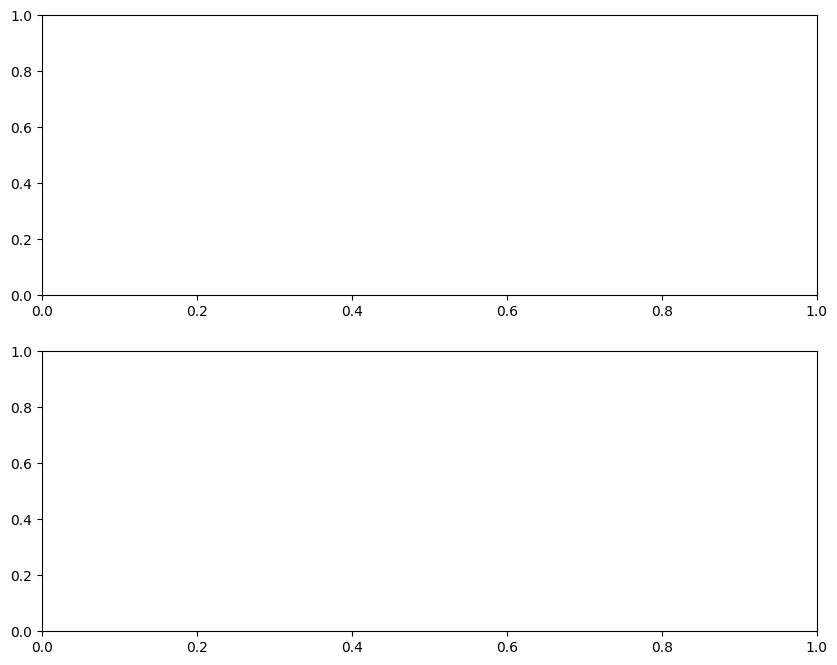

In [10]:
# 서브플롯 생성
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# 첫 번째 서브플롯 (pl1 데이터 시각화)
ax[0].plot(periods[l:], pl1['Test Loss'][l:], label='TE')
ax[0].set_title('TE')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Loss')
ax[0].legend()

# 두 번째 서브플롯 (pl2 데이터 시각화)
ax[1].plot(periods[l:], pl2['Test Loss'][l:], label='ETE')
ax[1].set_title('ETE')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Loss')
ax[1].legend()

# 그래프 사이 간격 조정
plt.tight_layout()
plt.savefig('TE&ETEto2024.png')
# 그래프 표시
plt.show()

In [11]:
class Config:
    # Data parameters
    N_E = 10
    MODEL = 'TENet'
    K_SIZE = [3, 5, 7]
    DECODER = 'GNN'
    HORIZON = 1
    NUM_ADJ = 1
    HIGHWAY_WINDOW = 0
    
    EPOCHS = 100
    BATCH_SIZE = 32
    
    
    SKIP_MODE = "none"
    ATTENTION_MODE = "naive"
    CHANNEL_SIZE = 12
    HID1 = 20
    HID2 = 30
    HIDRNN = 100
    RNN_LAYERS = 1
    HIDCNN = 12
    CNN_KERNEL = 6
    N_HEAD = 8
    D_K = 64
    D_V = 64
    SEED = 54321
    
    GPU = 0
    
    LOG_INTERVAL = 2000
    SAVE = 'model/model.pt'
    CUDA = True
    OPTIM = 'adam'
    LR = 0.001
    L1LOSS = False
    SKIP = 24
    HIDSKIP = 10
    NORMALIZE = 1
    OUTPUT_FUN = 'Linear'
    
    DEVICE = 'cuda:0'
    
    GCN_TRUE = True
    BUILDA_TRUE = True
    GCN_DEPTH = 2
    NUM_NODES = 8
    DROPOUT = 0.2
    SUBGRAPH_SIZE = 4
    NODE_DIM = 40
    DILATION_EXPONENTIAL = 2
    CONV_CHANNELS = 12
    RESIDUAL_CHANNELS = 12
    SKIP_CHANNELS = 32
    END_CHANNELS = 64
    IN_DIM = 1
    SEQ_IN_LEN = 32
    SEQ_OUT_LEN = 1
    LAYERS = 5
    WEIGHT_DECAY = 0.00001
    CLIP = 10
    PROPALPHA = 0.05
    TANHALPHA = 3
    NUM_SPLIT = 1
    STEP_SIZE = 100
    VALIDATION_FREQ=10

CONFIG = Config()


CONFIG.CUDA = torch.cuda.is_available()
if CONFIG.CUDA:
    torch.cuda.set_device(CONFIG.GPU)

In [12]:
import os
import numpy as np

logR_df = pd.read_csv('data/log_df_etf10.csv')

# 실험을 위한 파라미터 값 설정
window_sizes = [30, 60, 90]
training_periods = [250]
effectives = [False, True]

# For문을 통해 모든 조합에 대해 실험 수행
for training_period in tqdm(training_periods, leave=False):
    for window_size in tqdm(window_sizes, leave=False):
        for effective in tqdm(effectives, leave=False):
                    # ModelManager 객체 생성
                    manager = ModelManager(CONFIG, logR_df, window_size=window_size, training_period=training_period, threshold=None, Effective=effective)
                    
                    manager.train_and_evaluate()  # Example sizes in days
                    
                    # 결과 플롯 및 저장
                    manager.plot_results()
                    manager.save_results_to_excel()




  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

initial_data_x and y (250, 10) (220, 10)





  0%|          | 0/5082 [00:00<?, ?it/s]


  0%|          | 10/5082 [00:03<32:13,  2.62it/s]


  1%|▏         | 73/5082 [00:03<03:18, 25.28it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2004-02-20.





  2%|▏         | 119/5082 [00:04<01:46, 46.57it/s]


  3%|▎         | 167/5082 [00:07<03:47, 21.61it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2004-10-05.





  4%|▍         | 206/5082 [00:11<05:00, 16.21it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2004-11-30.





  5%|▌         | 276/5082 [00:15<04:49, 16.61it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2005-03-11.





  7%|▋         | 351/5082 [00:19<04:24, 17.88it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2005-06-28.





  8%|▊         | 390/5082 [00:23<05:15, 14.87it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2005-08-23.





  9%|▊         | 442/5082 [00:27<05:25, 14.25it/s]


 10%|▉         | 499/5082 [00:27<03:39, 20.87it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2005-11-04.





 11%|█         | 536/5082 [00:31<04:31, 16.74it/s]


 12%|█▏        | 603/5082 [00:31<02:49, 26.38it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2006-03-23.





 12%|█▏        | 634/5082 [00:35<04:04, 18.17it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2006-07-20.





 13%|█▎        | 656/5082 [00:38<05:24, 13.64it/s]


 14%|█▍        | 724/5082 [00:38<03:06, 23.38it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2006-08-17.





 15%|█▍        | 756/5082 [00:42<04:15, 16.92it/s]


 16%|█▌        | 815/5082 [00:42<02:41, 26.38it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2007-01-26.





 17%|█▋        | 864/5082 [00:42<01:53, 37.06it/s]


 18%|█▊        | 927/5082 [00:46<02:40, 25.83it/s]


 20%|█▉        | 993/5082 [00:46<01:45, 38.88it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2007-10-11.





 21%|██        | 1050/5082 [00:50<02:29, 26.93it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2008-04-09.





 21%|██        | 1078/5082 [00:53<03:31, 18.97it/s]


 22%|██▏       | 1140/5082 [00:53<02:16, 28.95it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2008-05-08.





 23%|██▎       | 1173/5082 [00:57<03:16, 19.93it/s]


 24%|██▍       | 1243/5082 [00:57<01:59, 32.18it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2008-09-25.





 26%|██▌       | 1315/5082 [00:57<01:16, 49.43it/s]


 27%|██▋       | 1393/5082 [01:01<01:54, 32.25it/s]


 29%|██▉       | 1464/5082 [01:01<01:17, 46.40it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2009-08-18.





 30%|██▉       | 1509/5082 [01:05<02:04, 28.77it/s]


 31%|███       | 1569/5082 [01:05<01:27, 40.24it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2009-12-01.





 32%|███▏      | 1609/5082 [01:08<02:14, 25.79it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2010-05-17.





 32%|███▏      | 1638/5082 [01:12<03:10, 18.04it/s]


 34%|███▎      | 1707/5082 [01:12<01:56, 29.01it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2010-07-27.





 35%|███▍      | 1757/5082 [01:16<02:38, 20.99it/s]


 36%|███▌      | 1819/5082 [01:16<01:44, 31.11it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2011-01-27.





 37%|███▋      | 1855/5082 [01:20<02:35, 20.70it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2011-05-18.





 38%|███▊      | 1908/5082 [01:24<02:53, 18.27it/s]


 39%|███▊      | 1969/5082 [01:24<01:54, 27.31it/s]




Retrain shape :  (250, 10) (220, 10)
Change on day 2011-09-01.


 40%|███▉      | 2023/5082 [01:24<01:19, 38.24it/s]


 41%|████      | 2086/5082 [01:24<00:53, 55.74it/s]


 42%|████▏     | 2132/5082 [01:28<01:42, 28.88it/s]


 43%|████▎     | 2201/5082 [01:28<01:05, 43.86it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2012-05-18.
Retrain shape :  (250, 10) (220, 10)
Change on day 2012-11-26.





 44%|████▍     | 2245/5082 [01:36<02:48, 16.84it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2012-12-04.





 45%|████▍     | 2276/5082 [01:39<03:22, 13.83it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2013-01-30.





 46%|████▌     | 2331/5082 [01:43<03:12, 14.27it/s]


 47%|████▋     | 2371/5082 [01:43<02:22, 18.99it/s]




Retrain shape :  (250, 10) (220, 10)
Change on day 2013-05-10.


 48%|████▊     | 2432/5082 [01:43<01:30, 29.13it/s]


 49%|████▉     | 2499/5082 [01:47<01:48, 23.89it/s]


 51%|█████     | 2583/5082 [01:47<01:04, 38.62it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2014-01-09.





 52%|█████▏    | 2626/5082 [01:51<01:36, 25.53it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2014-06-23.
Retrain shape :  (250, 10) (220, 10)
Change on day 2014-07-15.





 52%|█████▏    | 2656/5082 [01:58<03:09, 12.80it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2014-07-30.





 53%|█████▎    | 2678/5082 [02:02<03:39, 10.94it/s]


 54%|█████▍    | 2747/5082 [02:02<02:05, 18.57it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2014-09-15.





 55%|█████▍    | 2790/5082 [02:06<02:26, 15.62it/s]


 56%|█████▌    | 2850/5082 [02:06<01:34, 23.72it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2015-03-09.





 57%|█████▋    | 2920/5082 [02:06<00:58, 36.85it/s]


 59%|█████▉    | 2987/5082 [02:10<01:15, 27.88it/s]


 60%|██████    | 3056/5082 [02:10<00:49, 40.81it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2015-12-16.





 61%|██████▏   | 3117/5082 [02:10<00:34, 56.26it/s]


 62%|██████▏   | 3165/5082 [02:14<01:05, 29.08it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2016-06-30.





 63%|██████▎   | 3199/5082 [02:18<01:34, 20.01it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2016-10-13.





 63%|██████▎   | 3223/5082 [02:21<02:05, 14.84it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2016-11-22.





 64%|██████▍   | 3240/5082 [02:25<02:47, 11.01it/s]


 65%|██████▍   | 3303/5082 [02:25<01:32, 19.24it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2016-12-13.





 66%|██████▌   | 3331/5082 [02:29<02:00, 14.57it/s]


 67%|██████▋   | 3401/5082 [02:29<01:06, 25.42it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2017-04-25.





 68%|██████▊   | 3466/5082 [02:29<00:41, 39.24it/s]


 69%|██████▉   | 3521/5082 [02:29<00:28, 54.88it/s]


 71%|███████   | 3586/5082 [02:29<00:18, 79.82it/s]


 72%|███████▏  | 3639/5082 [02:33<00:43, 33.08it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2018-06-06.





 72%|███████▏  | 3678/5082 [02:37<01:03, 22.22it/s]


 74%|███████▍  | 3753/5082 [02:37<00:37, 35.60it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2018-09-14.





 75%|███████▌  | 3815/5082 [02:37<00:25, 50.56it/s]


 76%|███████▌  | 3863/5082 [02:41<00:42, 28.65it/s]


 77%|███████▋  | 3922/5082 [02:41<00:28, 40.71it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2019-04-17.





 78%|███████▊  | 3986/5082 [02:45<00:39, 27.74it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2019-12-05.





 79%|███████▉  | 4016/5082 [02:49<00:55, 19.36it/s]


 80%|████████  | 4071/5082 [02:49<00:36, 27.98it/s]




Retrain shape :  (250, 10) (220, 10)
Change on day 2020-01-17.


 81%|████████▏ | 4134/5082 [02:49<00:22, 41.63it/s]


 82%|████████▏ | 4182/5082 [02:49<00:16, 55.38it/s]


 84%|████████▍ | 4263/5082 [02:49<00:09, 87.72it/s]


 85%|████████▍ | 4318/5082 [02:53<00:21, 34.78it/s]


 86%|████████▌ | 4374/5082 [02:53<00:14, 47.61it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2021-03-15.





 87%|████████▋ | 4435/5082 [02:53<00:09, 66.59it/s]


 89%|████████▊ | 4508/5082 [02:53<00:05, 97.08it/s]


 90%|████████▉ | 4571/5082 [02:57<00:12, 41.46it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2022-04-01.





 91%|█████████ | 4611/5082 [03:01<00:18, 25.45it/s]


 92%|█████████▏| 4676/5082 [03:01<00:10, 37.31it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2022-05-20.





 93%|█████████▎| 4715/5082 [03:05<00:15, 23.52it/s]


 94%|█████████▍| 4787/5082 [03:05<00:08, 36.54it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2022-10-07.





 95%|█████████▌| 4831/5082 [03:09<00:10, 23.94it/s]


 96%|█████████▌| 4871/5082 [03:09<00:06, 30.92it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2023-04-17.





 96%|█████████▋| 4904/5082 [03:13<00:09, 19.31it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2023-06-22.





 97%|█████████▋| 4938/5082 [03:16<00:09, 15.36it/s]


 99%|█████████▊| 5009/5082 [03:16<00:02, 26.18it/s]




Retrain shape :  (250, 10) (220, 10)
Change on day 2023-09-19.


100%|██████████| 5082/5082 [03:16<00:00, 25.80it/s]


Number of chage :  51
Results will be saved in: C:\Users\sangheon\Desktop\Hurst_TE_RealizedVol\False_30_250_20240910_223125




 50%|█████     | 1/2 [03:22<03:22, 202.52s/it]

initial_data_x and y (250, 10) (220, 10)





  0%|          | 0/5082 [00:00<?, ?it/s]


  0%|          | 10/5082 [00:06<57:08,  1.48it/s]


  2%|▏         | 77/5082 [00:06<05:26, 15.31it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2004-02-20.





  3%|▎         | 144/5082 [00:06<02:24, 34.10it/s]


  4%|▍         | 196/5082 [00:14<05:48, 14.01it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2004-10-05.





  4%|▍         | 228/5082 [00:21<09:04,  8.92it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2004-11-30.





  5%|▌         | 276/5082 [00:28<09:58,  8.03it/s]


  7%|▋         | 337/5082 [00:28<06:03, 13.04it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2005-03-11.





  7%|▋         | 367/5082 [00:35<08:15,  9.52it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2005-06-28.





  8%|▊         | 390/5082 [00:41<10:33,  7.41it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2005-08-23.





  9%|▊         | 442/5082 [00:47<10:02,  7.71it/s]


 10%|▉         | 502/5082 [00:47<06:08, 12.44it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2005-11-04.





 11%|█         | 536/5082 [00:54<08:11,  9.26it/s]


 12%|█▏        | 612/5082 [00:54<04:36, 16.14it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2006-03-23.
Retrain shape :  (250, 10) (220, 10)
Change on day 2006-07-20.





 13%|█▎        | 648/5082 [01:08<09:56,  7.43it/s]


 14%|█▍        | 721/5082 [01:08<05:56, 12.22it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2006-08-17.





 15%|█▌        | 768/5082 [01:14<06:58, 10.30it/s]


 17%|█▋        | 849/5082 [01:14<04:10, 16.93it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2007-01-26.





 18%|█▊        | 921/5082 [01:14<02:45, 25.16it/s]


 19%|█▉        | 976/5082 [01:22<04:28, 15.32it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2007-10-11.





 21%|██        | 1050/5082 [01:30<05:29, 12.22it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2008-04-09.





 21%|██        | 1078/5082 [01:39<07:49,  8.52it/s]


 23%|██▎       | 1147/5082 [01:39<05:00, 13.09it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2008-05-08.





 23%|██▎       | 1181/5082 [01:48<07:34,  8.59it/s]


 25%|██▍       | 1253/5082 [01:49<04:40, 13.67it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2008-09-25.





 25%|██▌       | 1292/5082 [01:49<03:37, 17.45it/s]


 27%|██▋       | 1366/5082 [01:49<02:14, 27.70it/s]


 27%|██▋       | 1366/5082 [02:02<02:14, 27.70it/s]


 27%|██▋       | 1393/5082 [02:03<07:10,  8.58it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2009-08-18.





 29%|██▉       | 1466/5082 [02:14<07:45,  7.76it/s]


 30%|███       | 1536/5082 [02:14<04:59, 11.84it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2009-12-01.





 31%|███▏      | 1591/5082 [02:22<06:04,  9.57it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2010-05-17.





 32%|███▏      | 1630/5082 [02:31<07:31,  7.65it/s]


 33%|███▎      | 1697/5082 [02:31<04:48, 11.74it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2010-07-27.





 35%|███▍      | 1757/5082 [02:39<05:34,  9.95it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2011-01-27.





 36%|███▌      | 1834/5082 [02:47<05:25,  9.99it/s]


 37%|███▋      | 1902/5082 [02:47<03:39, 14.46it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2011-05-18.





 38%|███▊      | 1936/5082 [02:55<05:18,  9.89it/s]


 39%|███▉      | 2001/5082 [02:55<03:29, 14.73it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2011-09-01.





 41%|████      | 2064/5082 [02:56<02:21, 21.29it/s]


 41%|████▏     | 2108/5082 [03:05<04:15, 11.63it/s]


 43%|████▎     | 2174/5082 [03:05<02:46, 17.45it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2012-05-18.





 44%|████▎     | 2217/5082 [03:12<04:06, 11.62it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2012-11-26.





 44%|████▍     | 2247/5082 [03:20<05:25,  8.70it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2012-12-04.





 45%|████▍     | 2268/5082 [03:26<06:59,  6.71it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2013-01-30.





 46%|████▌     | 2331/5082 [03:33<06:05,  7.53it/s]


 47%|████▋     | 2405/5082 [03:33<03:32, 12.62it/s]




Retrain shape :  (250, 10) (220, 10)
Change on day 2013-05-10.


 48%|████▊     | 2445/5082 [03:33<02:40, 16.42it/s]


 49%|████▉     | 2499/5082 [03:40<03:32, 12.17it/s]


 50%|████▉     | 2531/5082 [03:40<02:47, 15.27it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2014-01-09.





 50%|█████     | 2562/5082 [03:41<02:09, 19.44it/s]


 51%|█████▏    | 2612/5082 [03:47<03:12, 12.83it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2014-06-23.





 52%|█████▏    | 2632/5082 [03:53<04:44,  8.60it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2014-07-15.





 52%|█████▏    | 2646/5082 [04:00<06:44,  6.03it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2014-07-30.





 53%|█████▎    | 2670/5082 [04:06<07:47,  5.16it/s]


 53%|█████▎    | 2702/5082 [04:07<05:12,  7.62it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2014-09-15.





 54%|█████▍    | 2746/5082 [04:07<03:08, 12.40it/s]


 55%|█████▍    | 2777/5082 [04:07<02:15, 17.01it/s]


 55%|█████▌    | 2803/5082 [04:14<04:17,  8.84it/s]


 56%|█████▋    | 2861/5082 [04:14<02:20, 15.78it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2015-03-09.





 57%|█████▋    | 2920/5082 [04:14<01:24, 25.57it/s]


 59%|█████▉    | 2987/5082 [04:22<02:25, 14.40it/s]


 60%|██████    | 3055/5082 [04:22<01:31, 22.27it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2015-12-16.





 61%|██████▏   | 3122/5082 [04:31<02:26, 13.34it/s]


 63%|██████▎   | 3189/5082 [04:31<01:36, 19.57it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2016-06-30.
Retrain shape :  (250, 10) (220, 10)
Change on day 2016-10-13.





 63%|██████▎   | 3189/5082 [04:42<01:36, 19.57it/s]


 63%|██████▎   | 3223/5082 [04:48<04:14,  7.29it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2016-11-22.





 64%|██████▎   | 3237/5082 [04:57<05:39,  5.44it/s]


 65%|██████▌   | 3311/5082 [04:57<03:06,  9.52it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2016-12-13.





 66%|██████▌   | 3353/5082 [05:04<03:38,  7.92it/s]


 67%|██████▋   | 3427/5082 [05:05<02:07, 13.01it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2017-04-25.





 69%|██████▉   | 3497/5082 [05:05<01:20, 19.75it/s]


 70%|███████   | 3572/5082 [05:05<00:50, 29.86it/s]


 71%|███████▏  | 3630/5082 [05:12<01:23, 17.48it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2018-06-06.





 72%|███████▏  | 3678/5082 [05:19<01:50, 12.70it/s]


 73%|███████▎  | 3709/5082 [05:19<01:28, 15.45it/s]




Retrain shape :  (250, 10) (220, 10)
Change on day 2018-09-14.


 74%|███████▍  | 3782/5082 [05:19<00:52, 24.76it/s]


 75%|███████▌  | 3825/5082 [05:26<01:30, 13.94it/s]


 76%|███████▋  | 3886/5082 [05:26<00:58, 20.61it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2019-04-17.





 77%|███████▋  | 3926/5082 [05:26<00:43, 26.46it/s]


 78%|███████▊  | 3986/5082 [05:33<01:08, 15.98it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2019-12-05.





 79%|███████▉  | 4015/5082 [05:40<01:41, 10.54it/s]


 81%|████████  | 4092/5082 [05:40<00:55, 17.91it/s]




Retrain shape :  (250, 10) (220, 10)
Change on day 2020-01-17.


 82%|████████▏ | 4158/5082 [05:40<00:34, 26.68it/s]


 83%|████████▎ | 4212/5082 [05:40<00:23, 36.51it/s]


 84%|████████▍ | 4289/5082 [05:40<00:14, 56.04it/s]


 86%|████████▌ | 4346/5082 [05:50<00:45, 16.22it/s]


 87%|████████▋ | 4420/5082 [05:50<00:27, 24.34it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2021-03-15.





 88%|████████▊ | 4474/5082 [05:50<00:18, 32.47it/s]


 89%|████████▉ | 4545/5082 [05:50<00:11, 47.37it/s]


 91%|█████████ | 4602/5082 [05:58<00:24, 19.86it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2022-04-01.





 91%|█████████▏| 4642/5082 [06:05<00:35, 12.57it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2022-05-20.





 93%|█████████▎| 4701/5082 [06:13<00:37, 10.22it/s]


 94%|█████████▍| 4771/5082 [06:13<00:20, 15.51it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2022-10-07.





 95%|█████████▌| 4831/5082 [06:22<00:21, 11.66it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2023-04-17.





 96%|█████████▌| 4877/5082 [06:30<00:22,  9.26it/s]

Retrain shape :  (250, 10) (220, 10)
Change on day 2023-06-22.





 97%|█████████▋| 4938/5082 [06:37<00:16,  8.82it/s]


 99%|█████████▊| 5010/5082 [06:37<00:05, 13.45it/s]




Retrain shape :  (250, 10) (220, 10)
Change on day 2023-09-19.


100%|██████████| 5082/5082 [06:38<00:00, 12.77it/s]


Number of chage :  51
Results will be saved in: C:\Users\sangheon\Desktop\Hurst_TE_RealizedVol\True_30_250_20240910_223812




100%|██████████| 2/2 [10:09<00:00, 322.86s/it]

                                              
 33%|███▎      | 1/3 [10:09<20:19, 609.62s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

initial_data_x and y (250, 10) (190, 10)


TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.

In [ ]:
# Configuration and initialization
fin = open("/Users/sangheon/Desktop/CauGNN-main/TENet-master/data/log_df_etf10.txt")
data = np.loadtxt(fin, delimiter=',')
manager = ModelManager(CONFIG, data, threshold=None, Effective=True, volatility_type=1, num_change_te=None, direction=None)
manager.train_and_evaluate(window_size=32, training_period=750, testing_period=250)  # Example sizes in days
manager.plot_results()
manager.save_results_to_excel()

In [ ]:
'''
변수
training period size : big window size of train
testing period size : big window size of test & big window moving size
window_size : small window moving size
threshold : TE or ETE threshold
volatility type : , 0 for log return, 1 for absolute log return, 2 for realized volatility

horizon : 1 (small window moving size) / Fixed
training rate : 0.7 in train set(on training period size) & Shuffled / Fixed
validation rate : 0.3 in train set / Fixed

changing point index(TE 임계값 넘는 지점)
changing point list
TE list
ETE list
Loss list of each stock
Loss list of all


특정 Threshold에 따라 모델 변경
전체 ETF의 TE 평균, inflow TE의 평균, outflow TE의 평균, inflow의 평균이 threshold를 넘는 ETF의 개수, outflow의 평균이 threshold를 넘는 ETF의 개수
총 5개의 경우

공통
window size : 3m, 6m, 1y, 3y, 5y
'''